In [15]:
import os
import joblib
import numpy   as np
import pandas  as pd
import seaborn as sns

# Maching Learning Stuff
from sklearn            import tree
from sklearn.tree       import plot_tree
from sklearn.tree       import export_text
from sklearn.tree       import DecisionTreeClassifier
from sklearn.metrics    import accuracy_score
from sklearn.metrics    import confusion_matrix
from sklearn.metrics    import f1_score

from collections import defaultdict

# Multi-threading Stuff
from concurrent.futures import ProcessPoolExecutor

# Plotting utilities
import matplotlib.pyplot as plt

# Import formatter
from matplotlib.ticker import FuncFormatter


plt.rcParams['font.family'] = 'monospace'

In [16]:
RATES = ["1500kbits", "3000kbits", "4500kbits", "6000kbits", "7500kbits", "50000kbits"]

In [17]:
VALUES = [0, 1, 2, 3]
LABELS = ["LD", "SD", "HD", "FULL-HD"]
COLORS = ["black", "red", "green", "blue"]

# Define the name of the new columns
NUMBER          = "id"
CLASS           = "class"
PREDICTED_CLASS = "predicted_class"
TESTBED_RATE    = "testbed_rate"
AVG_VIDEO_RATE  = "avg_video_rate"

# Define how many tests to use in dataset
N = 20
# Define how many tests to use in testset
K = 5

In [18]:
def get_video_class(kbits: float) -> int:
    if 0 <= kbits <= 288:
        return 0  # LD
    elif 289 <= kbits <= 1500:
        return 1  # SD
    elif 1501 <= kbits <= 6500:
        return 2  # HD
    elif 6501 <= kbits <= 8000:
        return 3  # FULL-HD
    
def format_bytes(num_bytes: float) -> str:
    units = ['B', 'KB', 'MB', 'GB', 'TB']
    size  = float(num_bytes)

    for unit in units:
        if size < 1024:
            return f"{size:.2f} {unit}"
        size /= 1024
    return f"{size:.2f} {units[-1]}"

In [19]:
columns = []

for i in range(0, 10):    
    # Remove inner columns
    columns.append(f"ts_#{i}")
    columns.append(f"te_#{i}")
    #columns.append(f"s_bytes_all_#{i}")
    #columns.append(f"c_bytes_all_#{i}")
    columns.append(f"avg_video_rate_#{i}")
    columns.append(f"avg_audio_rate_#{i}")
    columns.append(f"video_requests_sequence_#{i}")
    columns.append(f"audio_requests_sequence_#{i}")
    
# Remove outer columns
columns.append(f"ts")
columns.append(f"te")
#columns.append(f"s_bytes_all")
#columns.append(f"c_bytes_all")
columns.append(f"avg_audio_rate")
columns.append(f"avg_video_rate")
columns.append(f"video_requests_sequence")
columns.append(f"audio_requests_sequence")

# Remove new columns
columns.append(CLASS)
columns.append(NUMBER)
columns.append(TESTBED_RATE)

In [20]:
traning_data = []
testing_data = []

In [21]:
# Locate on disk
curr_dir = os.getcwd()
protocol = "udp_data"

# Read N files for each rate
for rate in os.listdir(os.path.join(curr_dir, protocol)):
    files = os.listdir(os.path.join(curr_dir, protocol, rate))
    
    # Fill the testing data
    for file in files[0:K]:
        frame = pd.read_csv(os.path.join(curr_dir, protocol, rate, file), sep=" ")
        frame[CLASS]        = frame[AVG_VIDEO_RATE].apply(get_video_class)
        frame[TESTBED_RATE] = rate
        testing_data.append(frame)
    
    # Fill the learning data
    for file in files[K:N]:
        frame = pd.read_csv(os.path.join(curr_dir, protocol, rate, file), sep=" ")
        frame[CLASS]        = frame[AVG_VIDEO_RATE].apply(get_video_class)
        frame[TESTBED_RATE] = rate
        traning_data.append(frame)

# Give a unique number to each frame
for num, frame in enumerate(testing_data + traning_data, start=1):
    frame[NUMBER] = num

In [22]:
traning_data_frame = pd.concat(traning_data, ignore_index=True)
testing_data_frame = pd.concat(testing_data, ignore_index=True)

In [23]:
# summary = testing_data_frame.groupby(TESTBED_RATE)[NUMBER].apply(set)

# print(f"{'Rate':<20} {'Numbers'}")
# print("-" * 40)
# for rate, numbers in summary.items():
#     print(f"{rate:<20} {str(numbers)}")

In [24]:
def grid_search_cv(i: int, frames: list[pd.DataFrame], configurations: list):
    results = []
    
    # Validation set
    testing = frames[i]
    
    x_test  = testing.drop(columns=columns)
    y_test  = testing[CLASS]

    # Training set
    training = pd.concat([frames[j] for j in range(len(frames)) if j != i], ignore_index=True)
    x_train  = training.drop(columns=columns)
    y_train  = training[CLASS]
    
    for configuration in configurations:
        random_state      = 10
        max_depth         = configuration["max_depth"]
        criterion         = configuration["criterion"]
        min_samples_leaf  = configuration["min_samples_leaf"]
        
        # Generate a model with the configuration
        model = DecisionTreeClassifier(random_state=random_state, max_depth=max_depth, criterion=criterion, min_samples_leaf=min_samples_leaf)

        # Train the model
        model.fit(x_train, y_train)
        
        # Generate the predictions
        preds = model.predict(x_test)

        # Compute the accuracy
        accuracy = accuracy_score(y_test, preds)
        
        # Compute F1-scores
        macro_f1 = f1_score(y_test, preds, average='macro')
        micro_f1 = f1_score(y_test, preds, average='micro')
        
        # Add the result to the list
        results.append((model, configuration, accuracy, macro_f1, micro_f1)) 
    
    return results

configurations = [
    {"min_samples_leaf": ns, "max_depth": nl, "criterion": gn}
    for ns in range(20, 301, 20)
    for nl in range(1,  8, 1)
    for gn in ["gini", "entropy"]
]

results = []
with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = [executor.submit(grid_search_cv, i, traning_data, configurations) for i in range(len(traning_data))]
    for future in futures:
        results.extend(future.result())

In [25]:
scores = defaultdict(lambda: {
    "accuracy_scores":  [],
    "macro_f1_scores":  [],
    "micro_f1_scores":  [],
    "trained_models":   []
})

for model, configuration, accuracy, macro_f1, micro_f1 in results:
    key = tuple(configuration.items())
    scores[key]["accuracy_scores"].append(accuracy)
    scores[key]["macro_f1_scores"].append(macro_f1)
    scores[key]["micro_f1_scores"].append(micro_f1)
    scores[key]["trained_models"].append(model)
    
# Use the model that has the maximum micro-f1 as the best: save the model
# and its configuration in variables. Then, print a short report about the
# model that it has been found
best_model = None
best_confg = None
best_micro_f1 = -1

for key, value in scores.items():
    avg_micro_f1 = np.mean(value["micro_f1_scores"])
    if avg_micro_f1 > best_micro_f1:
        best_micro_f1 = avg_micro_f1
        best_confg    = dict(key)
        best_model    = value["trained_models"][np.argmax(value["micro_f1_scores"])]
        
        
print(f"Best Configuration: {best_confg}")

# Directory to save the model
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save the best model to disk
model_path = os.path.join(save_dir, "udp_decision_tree.pkl")
joblib.dump(best_model, model_path)

Best Configuration: {'min_samples_leaf': 20, 'max_depth': 4, 'criterion': 'entropy'}


['saved_models/udp_decision_tree.pkl']

In [26]:
csv_data = []
for key, value in scores.items():
    for model, accuracy, macro_f1, micro_f1 in zip(value["trained_models"], 
                                                   value["accuracy_scores"], 
                                                   value["macro_f1_scores"], 
                                                   value["micro_f1_scores"]):
        config = dict(key)
        config["accuracy"] = accuracy
        config["macro_f1"] = macro_f1
        config["micro_f1"] = micro_f1
        csv_data.append(config)

# Convert the data into a DataFrame
frame = pd.DataFrame(csv_data)

# Split the configuration dictionary into separate columns
frame.to_csv("udp_models_report.csv", index=False, sep=" ")

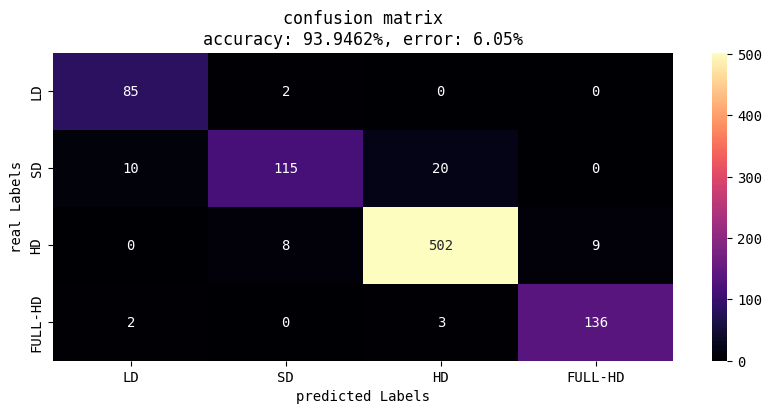

Feature              Importance
----------------------------------------
s_bytes_all         : 0.6307
idle                : 0.3437
min_span_#0         : 0.0126
min_span_#1         : 0.0103
std_span_#2         : 0.0027


In [27]:
x_test  = testing_data_frame.drop(columns=columns)
y_test  = testing_data_frame[CLASS]
    
# Test the model
preds = best_model.predict(x_test)
score = accuracy_score(y_test, preds)

classes              = best_model.classes_
features_importance  = list(best_model.feature_importances_)
features_names       = list(best_model.feature_names_in_)

# Compute the accuracy and the error rate
accuracy   = score
error_rate = 100 - accuracy * 100
accuracy   = accuracy * 100 

# Create confusion matrix
matrix = confusion_matrix(y_test, preds)

# Generate the plot
plt.figure(figsize=(10, 4))
sns.heatmap(matrix, 
            annot=True, fmt="d", cmap="magma", 
            xticklabels=[LABELS[i] for i in classes], 
            yticklabels=[LABELS[i] for i in classes])

# Render the plot
plt.xlabel("predicted Labels")
plt.ylabel("real Labels")
plt.title(f"confusion matrix\naccuracy: {accuracy:.4f}%, error: {error_rate:.2f}%")
plt.show()

# Print the feature importances
features = [(key, value) for key, value in zip(features_names, features_importance) if value > 0]
summary  = sorted(features, key=lambda x: x[1], reverse=True)
print(f"{'Feature':<20} {'Importance'}")
print("-" * 40)
for key, value in summary:
    print(f"{key:<20}: {value:.4f}")

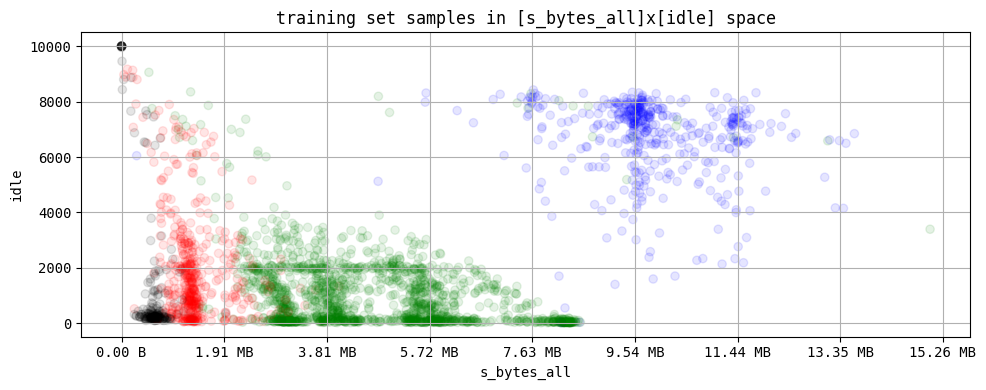

In [28]:
X = "s_bytes_all"
Y = "idle"
Z = CLASS

x_values = list(traning_data_frame[X])
y_values = list(traning_data_frame[Y])
z_values = list(traning_data_frame[Z])

# Map z values to corresponding colors in the COLORS list
colors = [COLORS[z] for z in z_values]

# Generate figure
fig, ax = plt.subplots(1, 1, figsize=(10, 4))  # Create figure and axes

# Scatter plot
scatter = ax.scatter(x_values, y_values, c=colors, alpha=0.1)

ax.set_xlabel(X)
ax.set_ylabel(Y)
ax.set_title(f"training set samples in [{X}]x[{Y}] space")

# Customize axis
ax.grid(True)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_bytes(x)))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [29]:
summary = testing_data_frame.groupby(TESTBED_RATE)[NUMBER].apply(set)

print(f"{'Rate':<20} {'Numbers'}")
print("-" * 40)
for rate, numbers in summary.items():
    print(f"{rate:<20} {str(numbers)}")

Rate                 Numbers
----------------------------------------
1500kbits            {26, 27, 28, 29, 30}
3000kbits            {6, 7, 8, 9, 10}
4500kbits            {11, 12, 13, 14, 15}
50000kbits           {21, 22, 23, 24, 25}
6000kbits            {16, 17, 18, 19, 20}
7500kbits            {1, 2, 3, 4, 5}


In [30]:
# Add the column with the predictions
testing_data_frame[PREDICTED_CLASS] = preds

# Generate a list with all failed predictions
failed_predictions = []

for pred in VALUES:
    for real in VALUES:
        frame = testing_data_frame[(testing_data_frame[PREDICTED_CLASS] == pred) & (testing_data_frame[CLASS] == real)]
        
        # Failed predictions
        if pred != real:
            if not frame.empty:
                failed_predictions.append(frame)

# Generate a frame
errors = pd.concat(failed_predictions, ignore_index=True)

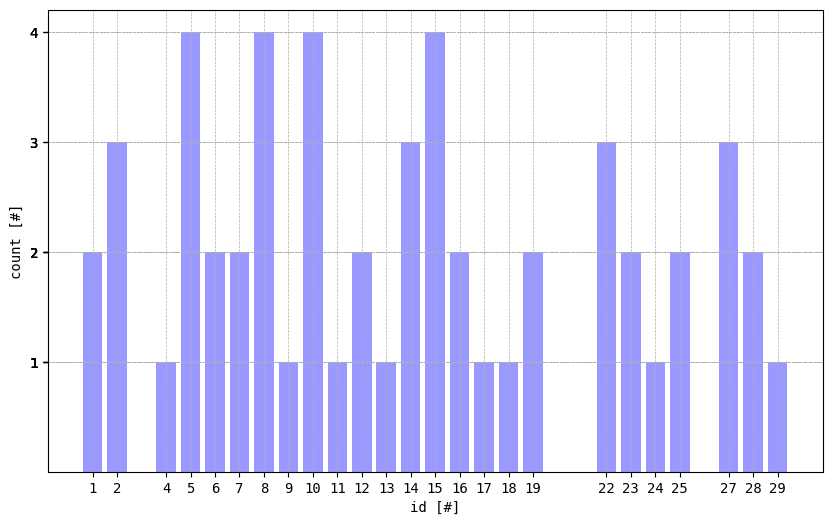

In [31]:
statistics = errors.groupby(NUMBER).size()

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar plot with red color and alpha 0.4
ax.bar(statistics.index, statistics.values, color='blue', alpha=0.4)

# Set the grid
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

# Set axis labels
ax.set_xlabel("id [#]")
ax.set_xticks(statistics.index)
ax.set_ylabel("count [#]")
ax.set_yticks(statistics.values)

# Show the plot
plt.show()

In [32]:
def volume_formatter(num_bytes: float) -> str:
    units = ['B', 'KB', 'MB', 'GB', 'TB']
    size  = float(num_bytes)

    for unit in units:
        if size < 1024:
            return f"{size:.2f} {unit}"
        size /= 1024
    return f"{size:.2f} {units[-1]}"

def time_formatter(millis: float) -> str:
    seconds = int(millis // 1000)
    remaining_millis = int(millis % 1000)
    if seconds > 0:
        return f"{seconds}s;{remaining_millis}ms"
    return f"{remaining_millis}ms"

In [33]:
intervals = [
    (0,    288,   "LD",      "black",  0.2),  # Lower alpha for more transparency
    (289,  1500,  "SD",      "red",    0.2),
    (1501, 6500,  "HD",      "green",  0.2),
    (6501, 8000,  "FULL-HD", "violet", 0.2)
]

In [34]:
def plot_report(test_num: int):
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(28, 8), sharex=True)
    
    # Select the test
    test = testing_data_frame[testing_data_frame[NUMBER] == test_num]
    
    # Select the timestamps
    timestamps_ts = np.array(test["ts"].astype(float).tolist()) / 1000
    timestamps_te = np.array(test["te"].astype(float).tolist()) / 1000
    
    # Define the min and max
    min_x  = timestamps_ts.min()
    max_x  = timestamps_te.max()
    xticks = np.arange(min_x, max_x + 1, 10)

    # Collect the predictions
    predictions = np.array(test[PREDICTED_CLASS])
    
    # Collect the groundtruth
    groundtruth = np.array(test[CLASS])
    
    # Collect the most iconic feature
    s_bytes_all_10s  = np.array(test["s_bytes_all"].tolist())
    
    # Collect the most iconic feature
    connection_idles = np.array(test["idle"].tolist())
    
    # Collect the HTTP requests
    http_requests = []
    for num, record in test.iterrows():
        requests = record["video_requests_sequence"]
        if len(requests) > 1:
            for request in requests.split("_"):
                t1, t2, rate = request.split("#")
                t1 = float(t1) / 1000
                http_requests.append((t1, rate))
        
    
    
    # Scatter predictions
    for i in range(len(predictions)):        
        x1 = timestamps_ts[i]
        x2 = timestamps_te[i]
        xd = (x1 + x2) / 2
        pred = predictions[i]
        real = groundtruth[i]
        
        # Select the color
        color = "green" if pred == real else "red"
        ax1.plot([x1, x2], [pred, pred], color=color, lw=2, label="prediction" if i == 0 else "")

        if pred != real:
            ax1.plot([x1, x2], [real, real], color="black", lw=1, ls="--", label="groundtruth" if i == 0 else "")
        if pred < real:
            ax1.annotate("", xy=(xd, real), xytext=(xd, pred), arrowprops=dict(arrowstyle="->", color="black", lw=0.5))
        if pred > real:
            ax1.annotate("", xy=(xd, pred), xytext=(xd, real), arrowprops=dict(arrowstyle="<-", color="black", lw=0.5))
            
                  
    # Scatter most iconic feature
    for i in range(len(predictions)):
        x1 = timestamps_ts[i]
        x2 = timestamps_te[i]
        xd = (x1 + x2) / 2
        y  = s_bytes_all_10s[i]
        
        ax2.plot([x1, x2], [y, y], color="black", lw=2, label=y)
        ax2.text(xd, y + 0.1, volume_formatter(y), ha='center', va='bottom', fontsize=10, color='black')
        ax2.fill_betweenx([0, y], x1=x1, x2=x2, color="gray", alpha=0.2)
        
    # Scatter most iconic feature
    for i in range(len(predictions)):
        x1 = timestamps_ts[i]
        x2 = timestamps_te[i]
        xd = (x1 + x2) / 2
        y  = connection_idles[i]
        
        ax3.plot([x1, x2], [y, y], color="black", lw=2, label=y)
        ax3.text(xd, y + 0.1, time_formatter(y), ha='center', va='bottom', fontsize=10, color='black')
        ax3.fill_betweenx([0, y], x1=x1, x2=x2, color="gray", alpha=0.2)
        
    # Scatter HTTP requests
    xvalues = []
    yvalues = []
    for i in range(len(http_requests)):
        x, y = http_requests[i]
        xvalues.append(x)
        yvalues.append(float(y))
    ax4.scatter(x=xvalues, y=yvalues, c="black", marker="o", lw=0.1, alpha=1)
    
    for (low, high, label, color, alpha) in intervals:
        ax4.axhspan(float(low), float(high), color=color, alpha=alpha, label=label)
            
    # Prediction figure    
    ax1.set_title(f"report test number={test_num}")
    ax1.set_xlabel("time [s]")
    ax1.set_xticks(xticks)
    ax1.set_xlim(min_x, max_x)
    ax1.set_ylabel("class [#]")
    ax1.set_yticks(VALUES)
    ax1.set_yticklabels([LABELS[i] for i in classes])
    ax1.grid(True, axis="both", linestyle="-", alpha=0.7)
    
    # First iconic feature   
    ax2.set_xlabel("time [s]")
    ax2.set_xticks(xticks)
    ax2.set_xlim(min_x, max_x)
    ax2.set_ylabel("bytes [B]")
    ax2.grid(True, axis="both", linestyle="-", alpha=0.7)
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: volume_formatter(x)))
    
    # Second iconic feature   
    ax3.set_xlabel("time [s]")
    ax3.set_xticks(xticks)
    ax3.set_xlim(min_x, max_x)
    ax3.set_ylabel("time [ms]")
    ax3.grid(True, axis="both", linestyle="-", alpha=0.7)
    
    # Second iconic feature   
    ax4.set_xlabel("time [s]")
    ax4.set_xticks(xticks)
    ax4.set_xlim(min_x, max_x)
    ax4.set_ylabel("rate [kbits]")
    ax4.grid(True, axis="both", linestyle="-", alpha=0.7)
    
    plt.show()

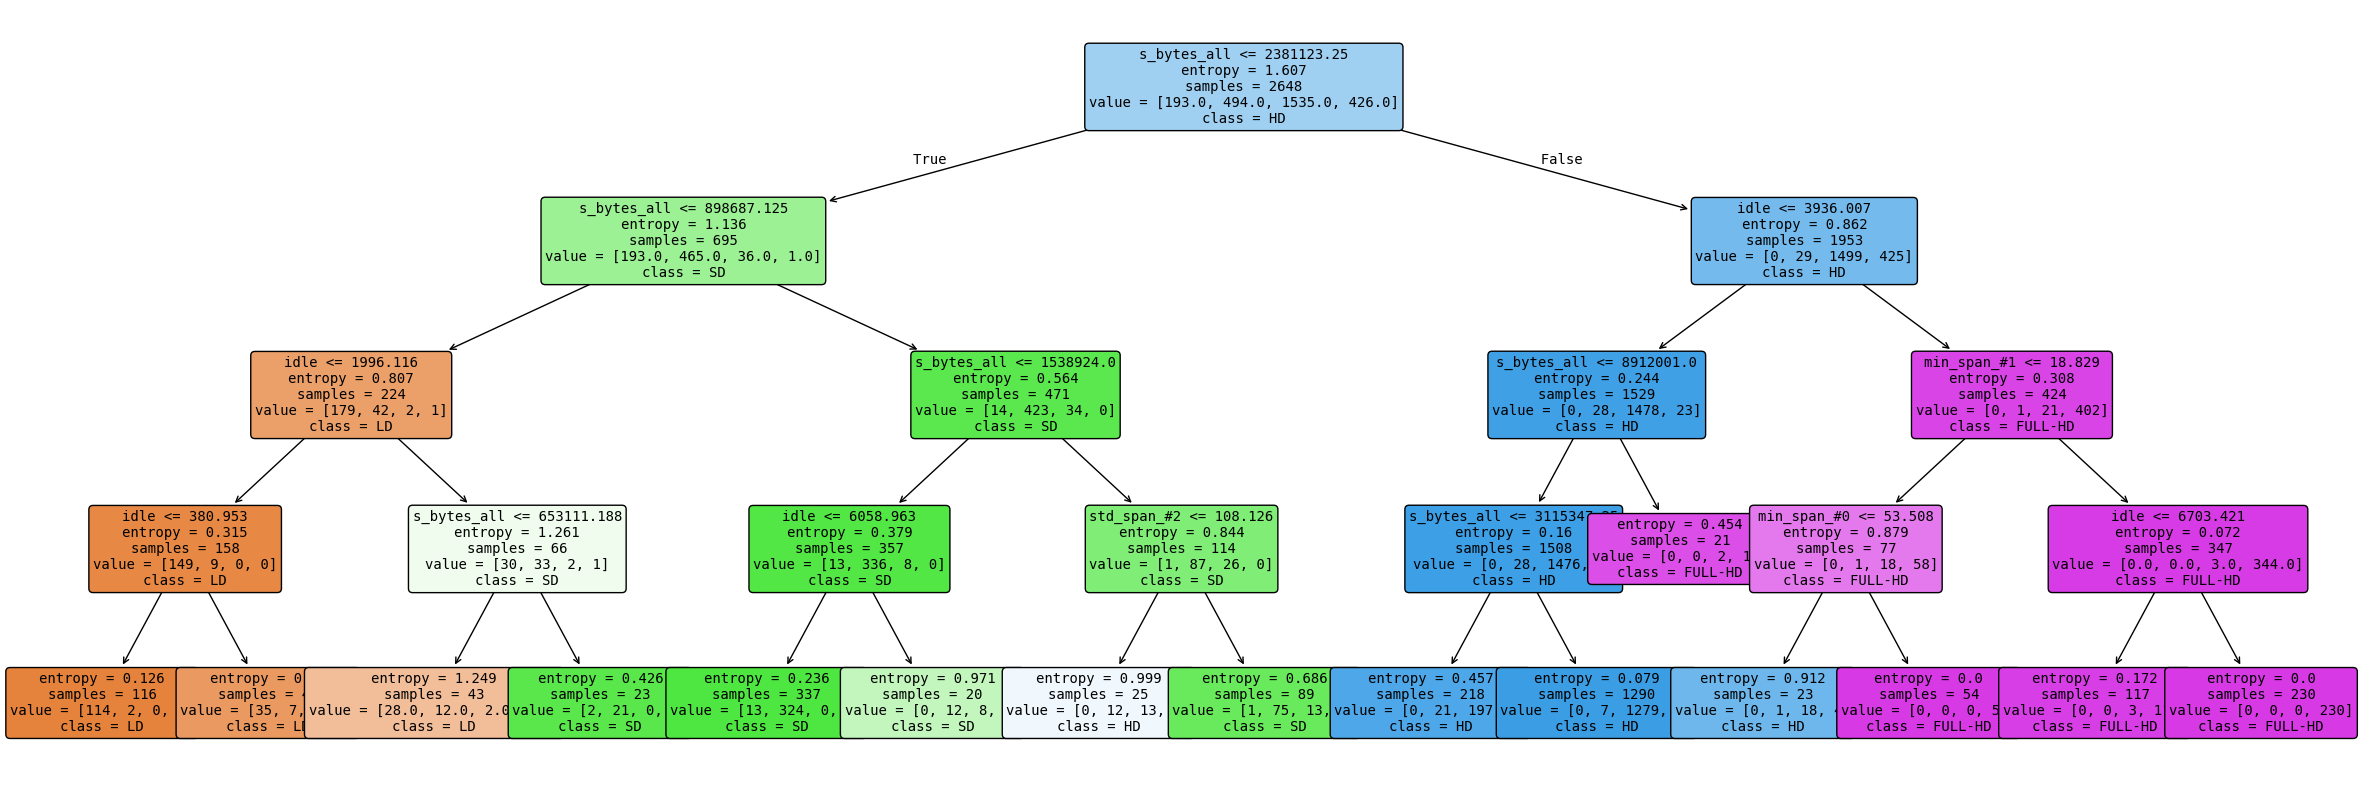

In [35]:
plt.figure(figsize=(30, 10))  # Adjust the figure size as needed
plot_tree(
    best_model, 
    feature_names=features_names, 
    class_names=[LABELS[i] for i in classes], filled=True, rounded=True, fontsize=10)
plt.show()

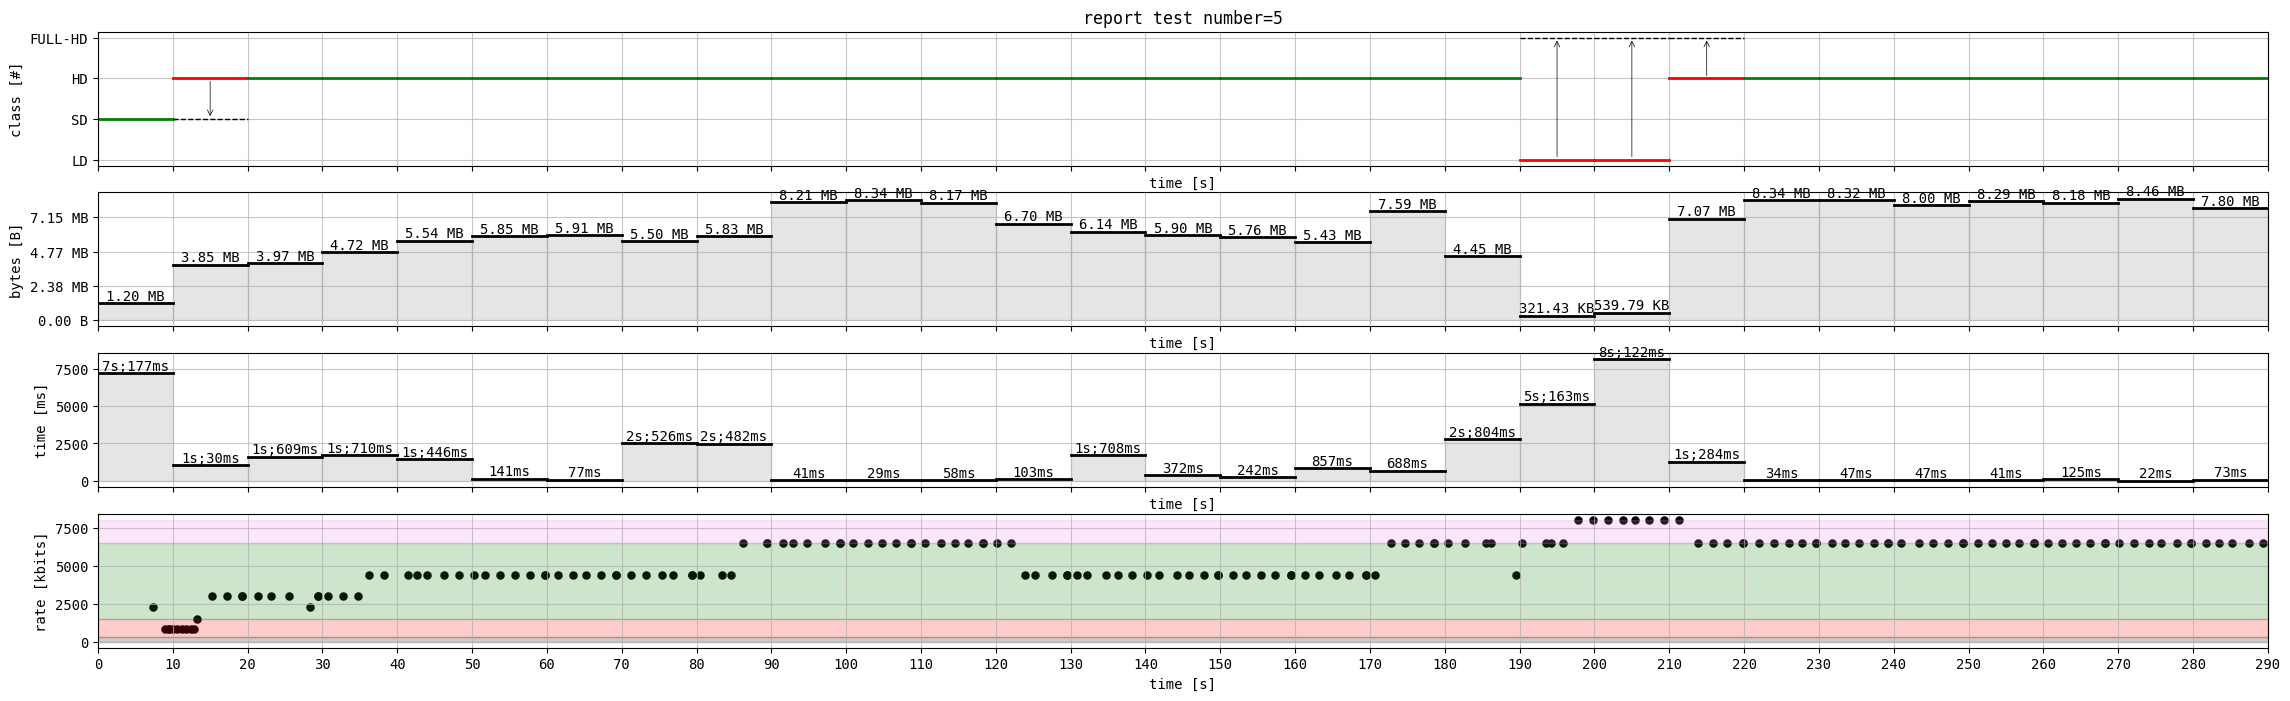

In [36]:
plot_report(test_num=5)